In [27]:
import scipy.io
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
mat = scipy.io.loadmat('OQC.mat')
import numpy as np
import torchinfo


In [28]:
variable = []
target = [] 

In [29]:
for i in np.float_(mat['data']):
    variable.append(i[:-1])
    target.append(i[-1])

In [30]:
data = torch.tensor(variable).float()
labels = torch.tensor(target).long()

In [31]:
from sklearn.model_selection import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size= 0.30, random_state=42)

In [32]:
train_ds = []
val_ds = []

for i in range(len(data_train)):
    train_ds.append((data_train[i],labels_train[i]))
    
    
for j in range(len(data_test)):
    val_ds.append((data_test[j],labels_test[j]))    

In [33]:
input_size = len(data_train[0])
num_classes = len(np.unique(labels))
input_size, num_classes

(48, 3)

In [34]:
for a,b in DataLoader(val_ds, 1 ,shuffle=True):
    print(a)
    print(b)
    break

tensor([[1.0000e+00, 1.0848e-01, 3.1754e-01, 1.1293e-03, 4.4444e-01, 4.4444e-01,
         6.6667e-01, 5.7143e-01, 7.5000e-01, 1.4286e-01, 2.5000e-01, 5.0000e-01,
         3.4988e-01, 1.0000e+00, 8.5313e-01, 3.6364e-01, 3.1250e-01, 7.5000e-01,
         0.0000e+00, 3.3333e-01, 0.0000e+00, 9.8765e-01, 3.0729e-01, 0.0000e+00,
         5.0000e-01, 9.6667e-01, 6.9271e-01, 6.1453e-01, 3.8547e-01, 1.2846e-02,
         6.6667e-01, 3.3465e-02, 0.0000e+00, 4.4558e-02, 0.0000e+00, 6.5098e-03,
         4.6108e-01, 6.1603e-01, 2.2879e-02, 7.1647e-01, 3.7255e-02, 2.1754e-01,
         1.0000e+00, 1.5061e-04, 5.0000e-01, 2.4918e-02, 2.4918e-02, 1.2346e-02]])
tensor([1])


## Task 1
You are asked to build a three-layer feed-forward neural network to solve the monitoring problem of injection molding machine. Your implementation must be in Pytorch and executable in Google Colab environments. The proportion of training and testing samples is 70:30 where your model must deliver the smallest testing error possible. In that case, you need to select the number of nodes of hidden layers, the number of epochs, the learning rates, the mini-batch size, etc. that lead to the smallest testing error. In this assignment, you have to use the SGD optimizer as exemplified in the lab materials under the mini-batch update fashion. The evaluation metric here is the classification error. No feature selection is allowed here.

In [35]:
def accuracy(outputs, labels):
    desc, predictor = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(predictor == labels).item() / len(predictor))

In [42]:
def fit(epochs, lr, model, batch_size = 1, opt_func=torch.optim.SGD):
    
    t_load = DataLoader(train_ds, batch_size, shuffle=True)
    v_load = DataLoader(val_ds, batch_size , shuffle=True)
    
    optimizer = opt_func(model.parameters(), lr)
    val_history = [] # for recording epoch-wise results
    train_history = []
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in t_load:
            loss = model.training_step(batch)
            print(loss)
            loss.backward()
            print(loss)
            optimizer.step()
            optimizer.zero_grad() ##reset the gradient
            break
        
        # Validation phase
        result = evaluate(model, v_load)
        model.epoch_end(epoch, result)
        val_history.append(result)
        
        t_result = evaluate(model, t_load)
        train_history.append(t_result)

    return [val_history,train_history]

In [43]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [54]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        predictor, response = batch
        out = self(predictor)
        loss = F.cross_entropy(out, response)
        return loss
    
    def validation_step(self, batch):
        predictor, response = batch 
        out = self(predictor)
        loss = F.cross_entropy(out, response)
        acc = accuracy(out, response)
        return {'val_loss': loss, 'val__acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [55]:
model = Model()

In [56]:
torchinfo.summary(model, input_size=[32, input_size])

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Linear: 1-1                            [32, 3]                   147
Total params: 147
Trainable params: 147
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [57]:
history1 = fit(50, 0.001, model)

predictor  tensor([[1.0000e+00, 1.2523e-01, 5.9242e-01, 1.7317e-03, 2.2222e-01, 4.4444e-01,
         2.2222e-01, 4.2857e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 2.5000e-01,
         3.5068e-01, 9.9439e-01, 8.2841e-01, 6.3636e-01, 2.5000e-01, 3.7500e-01,
         5.0000e-01, 3.3333e-01, 5.0000e-01, 7.4074e-02, 3.0623e-01, 1.0000e+00,
         5.0000e-01, 5.6667e-01, 6.9377e-01, 6.1266e-01, 3.8734e-01, 9.2589e-01,
         8.8889e-01, 3.3465e-02, 4.9981e-02, 2.3150e-01, 0.0000e+00, 6.9748e-03,
         4.6457e-01, 6.1603e-01, 2.2012e-02, 7.0968e-01, 3.7255e-02, 1.0258e-01,
         1.0000e+00, 3.7652e-05, 1.2500e-01, 2.3700e-02, 2.3700e-02, 9.2593e-01]])
out  tensor([[-0.1051, -0.2176, -0.0799]], grad_fn=<AddmmBackward>)
tensor(1.1838, grad_fn=<NllLossBackward>)
tensor(1.1838, grad_fn=<NllLossBackward>)
Epoch [0], val_loss: 1.1172, val_acc: 0.3002
predictor  tensor([[1.0000e+00, 1.4161e-01, 4.0284e-01, 2.5975e-03, 2.2222e-01, 4.4444e-01,
         2.2222e-01, 4.2857e-01, 2.5000e-01, 5.000

predictor  tensor([[1.0000e+00, 1.4161e-01, 4.2180e-01, 2.5599e-03, 1.1111e-01, 2.2222e-01,
         3.3333e-01, 4.2857e-01, 2.5000e-01, 5.0000e-01, 7.5000e-01, 0.0000e+00,
         3.5068e-01, 9.9599e-01, 7.7050e-01, 1.0000e+00, 3.1250e-01, 5.0000e-01,
         5.0000e-01, 3.3333e-01, 5.0000e-01, 9.0864e-02, 3.0517e-01, 3.3333e-01,
         5.0000e-01, 6.0000e-01, 6.9483e-01, 6.1453e-01, 3.8547e-01, 9.0958e-01,
         8.8889e-01, 3.3465e-02, 4.9981e-02, 2.3201e-01, 0.0000e+00, 7.4398e-03,
         4.6008e-01, 6.1603e-01, 2.3226e-02, 6.8930e-01, 3.7255e-02, 7.8843e-01,
         1.0000e+00, 3.7652e-05, 1.2500e-01, 2.5293e-02, 2.5293e-02, 9.0914e-01]])
out  tensor([[-0.1468, -0.1434,  0.0536]], grad_fn=<AddmmBackward>)
tensor(1.1710, grad_fn=<NllLossBackward>)
tensor(1.1710, grad_fn=<NllLossBackward>)
Epoch [10], val_loss: 1.1160, val_acc: 0.3047
predictor  tensor([[1.0000e+00, 6.9166e-02, 6.0664e-01, 1.5058e-04, 3.3333e-01, 5.5556e-01,
         3.3333e-01, 2.8571e-01, 5.0000e-01, 1.42

predictor  tensor([[1.0000e+00, 1.1285e-02, 8.1991e-01, 1.7317e-03, 3.3333e-01, 4.4444e-01,
         2.2222e-01, 4.2857e-01, 5.0000e-01, 5.0000e-01, 1.0000e+00, 2.5000e-01,
         3.5068e-01, 9.9439e-01, 8.1864e-01, 6.3636e-01, 3.7500e-01, 6.2500e-01,
         0.0000e+00, 6.6667e-01, 2.5000e-01, 7.9506e-02, 3.0623e-01, 6.6667e-01,
         5.0000e-01, 7.0000e-01, 6.9377e-01, 6.1453e-01, 3.8547e-01, 9.2045e-01,
         7.7778e-01, 3.3465e-02, 4.9981e-02, 2.3329e-01, 0.0000e+00, 6.9748e-03,
         4.6058e-01, 6.1603e-01, 2.3226e-02, 6.9779e-01, 3.7255e-02, 1.0556e-01,
         1.0000e+00, 3.7652e-05, 1.2500e-01, 2.5386e-02, 2.5386e-02, 9.2049e-01]])
out  tensor([[-0.1589, -0.1223, -0.1493]], grad_fn=<AddmmBackward>)
tensor(1.1141, grad_fn=<NllLossBackward>)
tensor(1.1141, grad_fn=<NllLossBackward>)
Epoch [20], val_loss: 1.1156, val_acc: 0.3059
predictor  tensor([[9.1091e-01, 1.4634e-01, 2.7014e-01, 2.5599e-03, 4.4444e-01, 3.3333e-01,
         3.3333e-01, 4.2857e-01, 2.5000e-01, 5.00

predictor  tensor([[1.0000e+00, 1.2705e-01, 3.9810e-01, 1.7693e-03, 3.3333e-01, 4.4444e-01,
         3.3333e-01, 7.1429e-01, 5.0000e-01, 5.7143e-01, 2.5000e-01, 2.5000e-01,
         3.5068e-01, 9.9439e-01, 8.3245e-01, 6.3636e-01, 2.5000e-01, 6.2500e-01,
         0.0000e+00, 6.6667e-01, 5.0000e-01, 7.6543e-02, 3.0517e-01, 3.3333e-01,
         5.0000e-01, 6.0000e-01, 6.9483e-01, 6.1453e-01, 3.8547e-01, 9.2342e-01,
         1.0000e+00, 3.3465e-02, 4.9981e-02, 2.2996e-01, 0.0000e+00, 7.3468e-03,
         4.6158e-01, 6.1603e-01, 2.2706e-02, 6.9610e-01, 3.7255e-02, 8.4699e-02,
         1.0000e+00, 3.7652e-05, 1.2500e-01, 2.4543e-02, 2.4543e-02, 9.2346e-01]])
out  tensor([[-0.0513, -0.0254, -0.0932]], grad_fn=<AddmmBackward>)
tensor(1.0678, grad_fn=<NllLossBackward>)
tensor(1.0678, grad_fn=<NllLossBackward>)
Epoch [30], val_loss: 1.1149, val_acc: 0.3273
predictor  tensor([[1.0000e+00, 1.2523e-01, 4.9289e-01, 1.7317e-03, 3.3333e-01, 4.4444e-01,
         4.4444e-01, 5.7143e-01, 2.5000e-01, 5.00

predictor  tensor([[1.0000e+00, 1.4780e-01, 1.5640e-01, 2.5599e-03, 2.2222e-01, 3.3333e-01,
         2.2222e-01, 2.8571e-01, 5.0000e-01, 5.0000e-01, 0.0000e+00, 0.0000e+00,
         3.5068e-01, 9.9599e-01, 7.8749e-01, 1.0000e+00, 3.1250e-01, 5.0000e-01,
         0.0000e+00, 3.3333e-01, 2.5000e-01, 8.2963e-02, 3.0623e-01, 6.6667e-01,
         5.0000e-01, 6.3333e-01, 6.9377e-01, 6.1453e-01, 3.8547e-01, 9.1700e-01,
         1.0000e+00, 3.1496e-02, 4.9981e-02, 2.3508e-01, 0.0000e+00, 7.9048e-03,
         4.6457e-01, 6.1603e-01, 2.2706e-02, 7.1307e-01, 3.7255e-02, 2.8825e-01,
         1.0000e+00, 3.7652e-05, 1.2500e-01, 2.4543e-02, 2.4543e-02, 9.1704e-01]])
out  tensor([[-0.0920,  0.0125, -0.0402]], grad_fn=<AddmmBackward>)
tensor(1.0998, grad_fn=<NllLossBackward>)
tensor(1.0998, grad_fn=<NllLossBackward>)
Epoch [40], val_loss: 1.1131, val_acc: 0.3273
predictor  tensor([[1.0000e+00, 1.0448e-01, 6.0190e-01, 7.5290e-04, 4.4444e-01, 5.5556e-01,
         3.3333e-01, 5.7143e-01, 2.5000e-01, 2.14

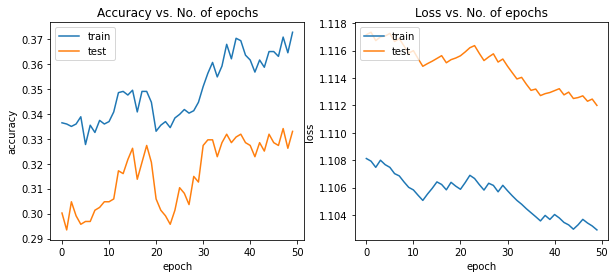

In [58]:
import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 2, figsize=(10,4))



val_history = history1[0]
train_history = history1[1]

val_accuracies = [result['val_acc'] for result in val_history ]
train_accuracies = [result['val_acc'] for result in train_history]

axes[0].plot(train_accuracies, label='Train')
axes[0].plot(val_accuracies, label='Test')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('accuracy')
axes[0].set_title('Accuracy vs. No. of epochs')
axes[0].legend(['train', 'test'], loc='upper left')


val_loss = [result['val_loss'] for result in val_history ]
train_loss = [result['val_loss'] for result in train_history]

axes[1].plot(train_loss, label='Train')
axes[1].plot(val_loss, label='Test')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('loss')
axes[1].set_title('Loss vs. No. of epochs')
axes[1].legend(['train', 'test'], loc='upper left')




## Task 2
You are asked to study the effect of network structure: hidden nodes, hidden layers to the classification
performance. That is, you try different network configurations and understand the patterns. Your
experiments have to be well-documented in your Jupyter notebook file and your report. It has to cover
different aspects of network configurations such as shallow network, wide network, deep network etc.

In [17]:
class Model_hidden_layer(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super().__init__()
        self.linear = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        predictor, response = batch 
        out = self(predictor)                  # Generate predictions
        loss = F.cross_entropy(out, response) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        predictor, response = batch 
        out = self(predictor)                    # Generate predictions
        loss = F.cross_entropy(out, response)   # Calculate loss
        acc = accuracy(out, response)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [18]:
input_size = len(data_train[0])
num_classes = len(np.unique(labels))
hidden_size = 4
input_size, num_classes

(48, 3)

In [19]:
model_layer = Model_hidden_layer(input_size, hidden_size, out_size = num_classes)

In [20]:
hidden_size = [4,8,16,32,64]
collections = []
for i in hidden_size:
    model_layer = Model_hidden_layer(input_size, i, out_size = num_classes)
    history_layer = fit(50, 0.001, model_layer)
    collections.append(history_layer)

Epoch [0], val_loss: 1.0587, val_acc: 0.4097
Epoch [1], val_loss: 0.9670, val_acc: 0.7291
Epoch [2], val_loss: 0.9033, val_acc: 0.7302
Epoch [3], val_loss: 0.8429, val_acc: 0.8025
Epoch [4], val_loss: 0.7973, val_acc: 0.8149
Epoch [5], val_loss: 0.7576, val_acc: 0.8352
Epoch [6], val_loss: 0.7230, val_acc: 0.8499
Epoch [7], val_loss: 0.6958, val_acc: 0.8634
Epoch [8], val_loss: 0.6693, val_acc: 0.8420
Epoch [9], val_loss: 0.6431, val_acc: 0.8973
Epoch [10], val_loss: 0.6224, val_acc: 0.9063
Epoch [11], val_loss: 0.6035, val_acc: 0.8657
Epoch [12], val_loss: 0.5860, val_acc: 0.8792
Epoch [13], val_loss: 0.5719, val_acc: 0.9221
Epoch [14], val_loss: 0.5543, val_acc: 0.8758
Epoch [15], val_loss: 0.5408, val_acc: 0.9086
Epoch [16], val_loss: 0.5325, val_acc: 0.8589
Epoch [17], val_loss: 0.5179, val_acc: 0.8916
Epoch [18], val_loss: 0.5070, val_acc: 0.8950
Epoch [19], val_loss: 0.4955, val_acc: 0.9029
Epoch [20], val_loss: 0.4872, val_acc: 0.8973
Epoch [21], val_loss: 0.4775, val_acc: 0.917

Epoch [29], val_loss: 0.4220, val_acc: 0.9131
Epoch [30], val_loss: 0.4156, val_acc: 0.9255
Epoch [31], val_loss: 0.4101, val_acc: 0.9244
Epoch [32], val_loss: 0.4044, val_acc: 0.9278
Epoch [33], val_loss: 0.3997, val_acc: 0.9176
Epoch [34], val_loss: 0.3940, val_acc: 0.9221
Epoch [35], val_loss: 0.3910, val_acc: 0.9244
Epoch [36], val_loss: 0.3851, val_acc: 0.9255
Epoch [37], val_loss: 0.3810, val_acc: 0.9255
Epoch [38], val_loss: 0.3766, val_acc: 0.9244
Epoch [39], val_loss: 0.3722, val_acc: 0.9233
Epoch [40], val_loss: 0.3691, val_acc: 0.9289
Epoch [41], val_loss: 0.3647, val_acc: 0.9289
Epoch [42], val_loss: 0.3616, val_acc: 0.9278
Epoch [43], val_loss: 0.3570, val_acc: 0.9278
Epoch [44], val_loss: 0.3542, val_acc: 0.9289
Epoch [45], val_loss: 0.3505, val_acc: 0.9300
Epoch [46], val_loss: 0.3477, val_acc: 0.9300
Epoch [47], val_loss: 0.3439, val_acc: 0.9300
Epoch [48], val_loss: 0.3409, val_acc: 0.9312
Epoch [49], val_loss: 0.3379, val_acc: 0.9323
Epoch [0], val_loss: 1.2169, val_a

In [21]:
def plot(history_model):
    f, axes = plt.subplots(len(history_model), 2, figsize=(15,30))
    count = 0
    
    for mod in history_model:
        val_history = mod[0]
        train_history = mod[1]

        val_accuracies = [result['val_acc'] for result in val_history ]
        train_accuracies = [result['val_acc'] for result in train_history]

        axes[count][0].plot(train_accuracies, label='Train')
        axes[count][0].plot(val_accuracies, label='Test')
        axes[count][0].set_xlabel('epoch')
        axes[count][0].set_ylabel('accuracy')
        axes[count][0].set_title('Accuracy vs. No. of epochs')
        axes[count][0].legend(['train', 'test'], loc='upper left')


        val_loss = [result['val_loss'] for result in val_history ]
        train_loss = [result['val_loss'] for result in train_history]

        axes[count][1].plot(train_loss, label='Train')
        axes[count][1].plot(val_loss, label='Test')
        axes[count][1].set_xlabel('epoch')
        axes[count][1].set_ylabel('loss')
        axes[count][1].set_title('Loss vs. No. of epochs')
        axes[count][1].legend(['train', 'test'], loc='upper left')
        count+=1

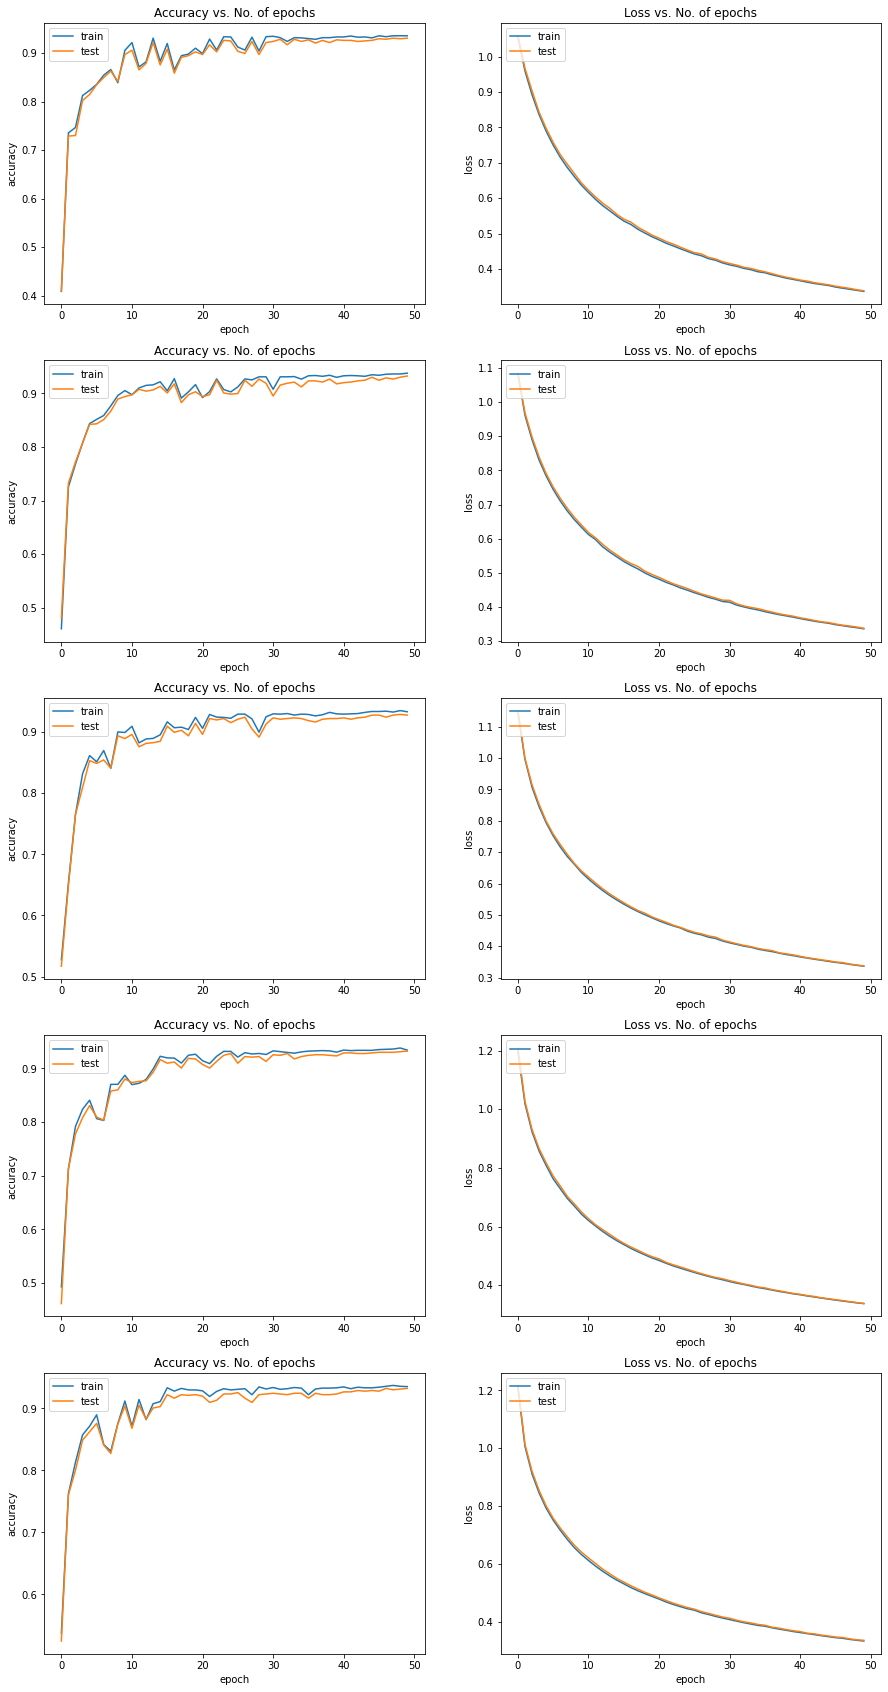

In [22]:
plot(collections)

## Task 3
You are asked to study the effect of learning rates. As with Task 2, your experiments have to be welldocumented. You need to give correct conclusion and give suggestion how learning rates should be
set. This includes possible adaptive learning rates where the value increases or decreases as the
increase of epochs. 

In [23]:
hidden_size = 64
collections = []
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5] 

for i in learning_rates:
    model_layer = Model_hidden_layer(input_size,hidden_size, out_size = num_classes)
    history_layer = fit(50, i, model_layer)
    collections.append(history_layer)

Epoch [0], val_loss: 1.2386, val_acc: 0.4932
Epoch [1], val_loss: 1.0300, val_acc: 0.6332
Epoch [2], val_loss: 0.9336, val_acc: 0.7212
Epoch [3], val_loss: 0.8637, val_acc: 0.8510
Epoch [4], val_loss: 0.8108, val_acc: 0.8657
Epoch [5], val_loss: 0.7710, val_acc: 0.8115
Epoch [6], val_loss: 0.7348, val_acc: 0.8115
Epoch [7], val_loss: 0.7016, val_acc: 0.8476
Epoch [8], val_loss: 0.6741, val_acc: 0.8533
Epoch [9], val_loss: 0.6489, val_acc: 0.9074
Epoch [10], val_loss: 0.6276, val_acc: 0.9074
Epoch [11], val_loss: 0.6079, val_acc: 0.8442
Epoch [12], val_loss: 0.5865, val_acc: 0.8950
Epoch [13], val_loss: 0.5711, val_acc: 0.9097
Epoch [14], val_loss: 0.5552, val_acc: 0.8781
Epoch [15], val_loss: 0.5420, val_acc: 0.9086
Epoch [16], val_loss: 0.5298, val_acc: 0.9266
Epoch [17], val_loss: 0.5172, val_acc: 0.9176
Epoch [18], val_loss: 0.5054, val_acc: 0.8962
Epoch [19], val_loss: 0.4953, val_acc: 0.9052
Epoch [20], val_loss: 0.4874, val_acc: 0.9266
Epoch [21], val_loss: 0.4777, val_acc: 0.902

Epoch [29], val_loss: 0.0523, val_acc: 1.0000
Epoch [30], val_loss: 0.0507, val_acc: 0.9989
Epoch [31], val_loss: 0.0507, val_acc: 0.9989
Epoch [32], val_loss: 0.0500, val_acc: 0.9977
Epoch [33], val_loss: 0.0507, val_acc: 0.9989
Epoch [34], val_loss: 0.0496, val_acc: 0.9966
Epoch [35], val_loss: 0.0530, val_acc: 0.9921
Epoch [36], val_loss: 0.0457, val_acc: 0.9989
Epoch [37], val_loss: 0.0444, val_acc: 1.0000
Epoch [38], val_loss: 0.0448, val_acc: 1.0000
Epoch [39], val_loss: 0.0473, val_acc: 0.9955
Epoch [40], val_loss: 0.0451, val_acc: 0.9966
Epoch [41], val_loss: 0.0415, val_acc: 1.0000
Epoch [42], val_loss: 0.0412, val_acc: 1.0000
Epoch [43], val_loss: 0.0420, val_acc: 0.9989
Epoch [44], val_loss: 0.0419, val_acc: 1.0000
Epoch [45], val_loss: 0.0391, val_acc: 1.0000
Epoch [46], val_loss: 0.0412, val_acc: 0.9966
Epoch [47], val_loss: 0.0446, val_acc: 0.9966
Epoch [48], val_loss: 0.0374, val_acc: 0.9989
Epoch [49], val_loss: 0.0410, val_acc: 0.9977
Epoch [0], val_loss: 0.3108, val_a

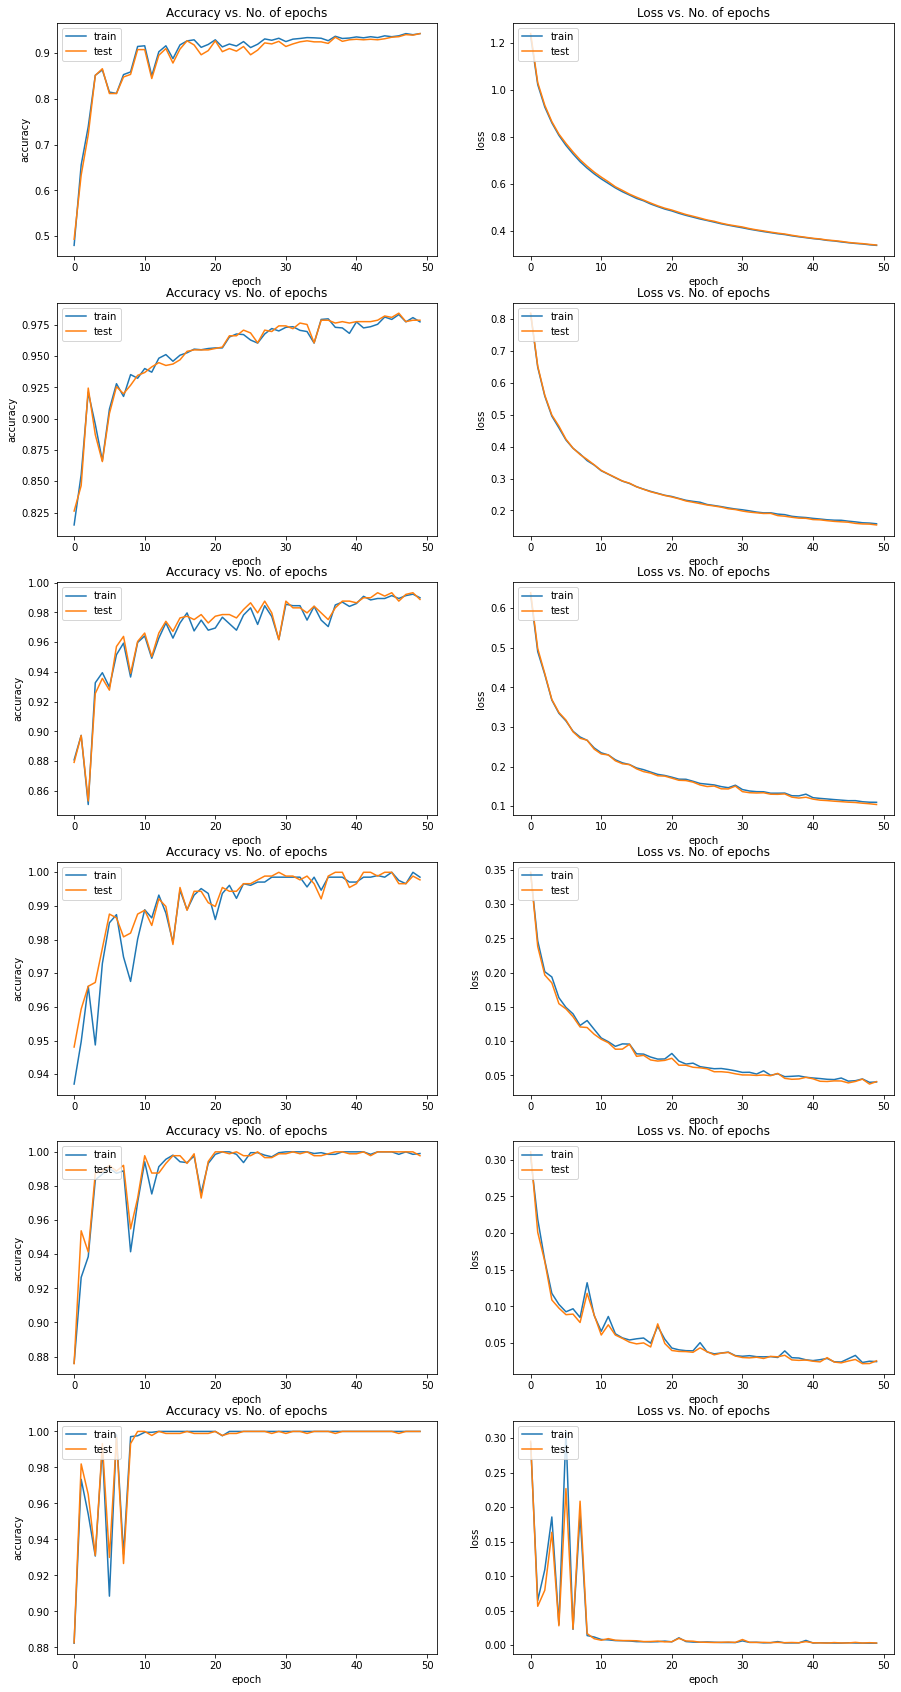

In [24]:
plot(collections)

## Task 4
You are asked to study the effect of mini-batch size. You can set mini-batch size to be 1 (stochastic
gradient descent), N (batch gradient descent) or any other size. The most important aspect is to be
conclusive with your finding. The mini-batch size really depends on the problem size. 

In [25]:
hidden_size = 64
collections = []
learning_rate = 0.001
batch_sizes = [1, 4, 16, 32, 64, 128] 


for i in batch_sizes:
    model_layer = Model_hidden_layer(input_size, hidden_size, out_size = num_classes)
    history_layer = fit(50, learning_rate ,model_layer, batch_size = i)
    collections.append(history_layer)

Epoch [0], val_loss: 1.2385, val_acc: 0.4989
Epoch [1], val_loss: 1.0310, val_acc: 0.6693
Epoch [2], val_loss: 0.9401, val_acc: 0.6772
Epoch [3], val_loss: 0.8681, val_acc: 0.7923
Epoch [4], val_loss: 0.8165, val_acc: 0.8081
Epoch [5], val_loss: 0.7761, val_acc: 0.7935
Epoch [6], val_loss: 0.7350, val_acc: 0.8284
Epoch [7], val_loss: 0.7037, val_acc: 0.8431
Epoch [8], val_loss: 0.6749, val_acc: 0.8589
Epoch [9], val_loss: 0.6489, val_acc: 0.8758
Epoch [10], val_loss: 0.6279, val_acc: 0.8894
Epoch [11], val_loss: 0.6086, val_acc: 0.8713
Epoch [12], val_loss: 0.5899, val_acc: 0.8849
Epoch [13], val_loss: 0.5723, val_acc: 0.8792
Epoch [14], val_loss: 0.5593, val_acc: 0.8646
Epoch [15], val_loss: 0.5434, val_acc: 0.9210
Epoch [16], val_loss: 0.5315, val_acc: 0.8905
Epoch [17], val_loss: 0.5188, val_acc: 0.9131
Epoch [18], val_loss: 0.5087, val_acc: 0.9052
Epoch [19], val_loss: 0.4973, val_acc: 0.9221
Epoch [20], val_loss: 0.4877, val_acc: 0.9165
Epoch [21], val_loss: 0.4792, val_acc: 0.916

Epoch [30], val_loss: 1.2442, val_acc: 0.4276
Epoch [31], val_loss: 1.2312, val_acc: 0.4430
Epoch [32], val_loss: 1.2199, val_acc: 0.4542
Epoch [33], val_loss: 1.2097, val_acc: 0.4612
Epoch [34], val_loss: 1.1984, val_acc: 0.4743
Epoch [35], val_loss: 1.1889, val_acc: 0.4839
Epoch [36], val_loss: 1.1792, val_acc: 0.4992
Epoch [37], val_loss: 1.1701, val_acc: 0.5039
Epoch [38], val_loss: 1.1623, val_acc: 0.5157
Epoch [39], val_loss: 1.1543, val_acc: 0.5292
Epoch [40], val_loss: 1.1465, val_acc: 0.5474
Epoch [41], val_loss: 1.1394, val_acc: 0.5518
Epoch [42], val_loss: 1.1320, val_acc: 0.5646
Epoch [43], val_loss: 1.1257, val_acc: 0.5720
Epoch [44], val_loss: 1.1189, val_acc: 0.5880
Epoch [45], val_loss: 1.1126, val_acc: 0.5915
Epoch [46], val_loss: 1.1074, val_acc: 0.5943
Epoch [47], val_loss: 1.1007, val_acc: 0.6041
Epoch [48], val_loss: 1.0954, val_acc: 0.6075
Epoch [49], val_loss: 1.0898, val_acc: 0.6176
Epoch [0], val_loss: 4.0952, val_acc: 0.0000
Epoch [1], val_loss: 3.9633, val_ac

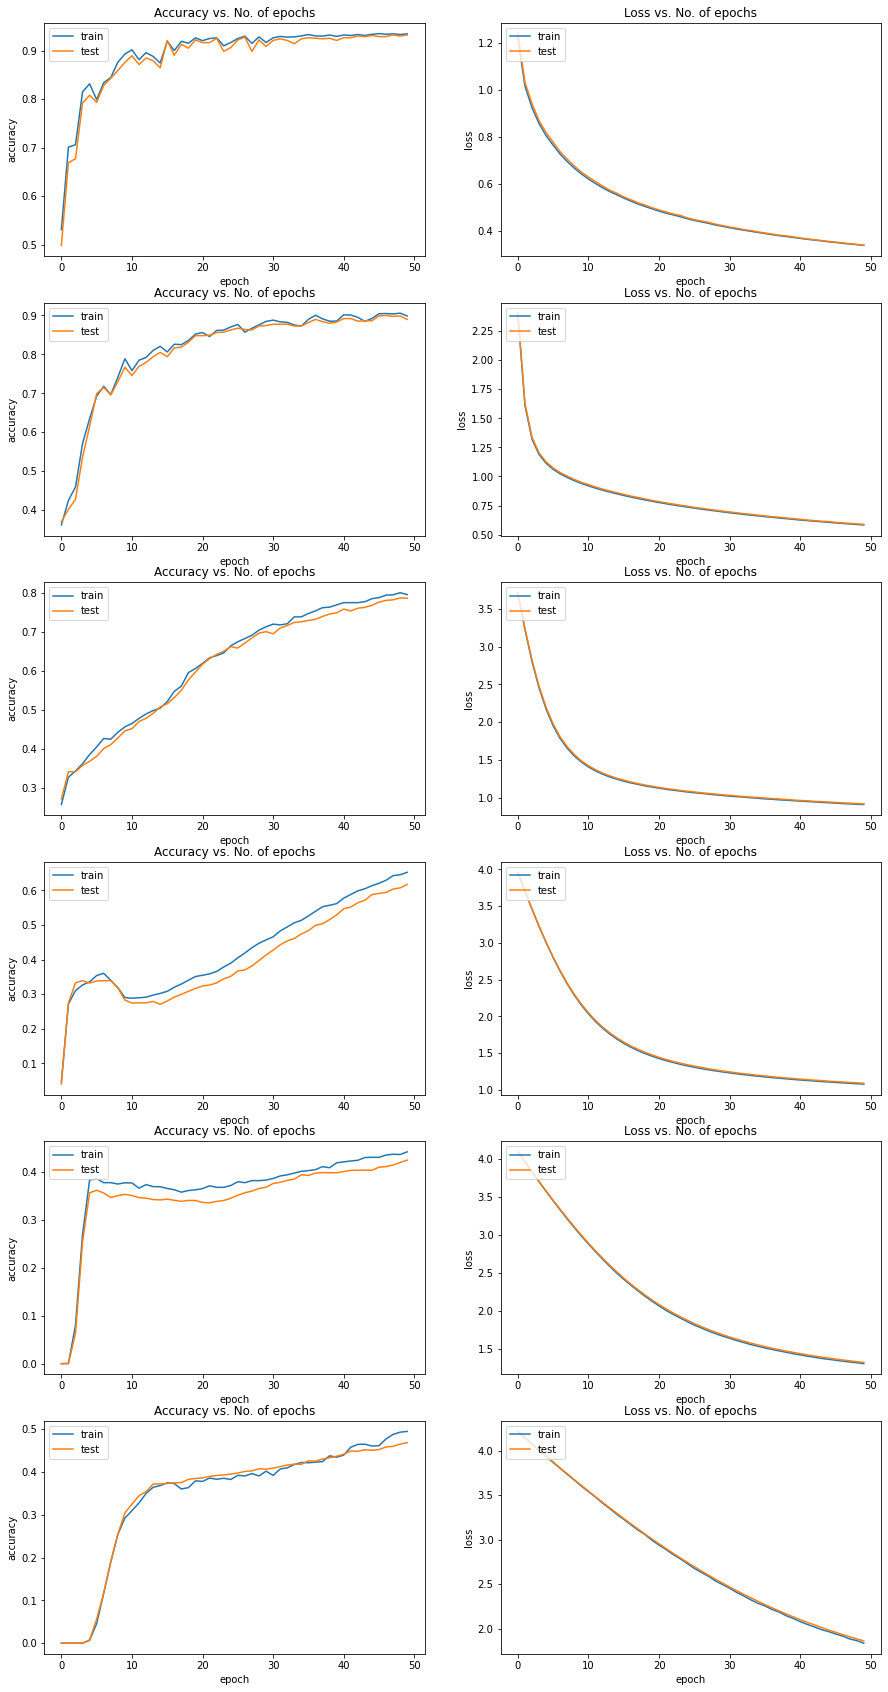

In [26]:
plot(collections)